In [5]:
# IS362-Final - Dan Collins - An Analysis of the Top 100 Books Sold on Amazon

In [9]:
# For this project, I used the dataset containing Amazon's Top 100 Bestselling Books from https://www.kaggle.com/datasets
# This includes information on the top 100 books sold in the last year, as well as an analysis of nearly 900 Amazon customers
# and their reviews of this list of books and others.
# This dataset contains 2 files: 1) 'customer_reviews.csv' and 'Top-100_Trending_Books.csv'

In [7]:
# The program uses a SQLite database, pandas, numpy, matplotlibg for graphs, scipy for correlation analysis

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

In [1]:
new_directory = r'C:\Users\dmcol\Documents\GitWork\IS362-Final'

In [4]:
os.chdir(new_directory)

In [8]:
# After creating a SQLite database called 'amazonbooks.db', the program starts by connecting to it
conn = sqlite3.connect('amazonbooks.db')

In [12]:
# Here is a query of the database to find the top 10 reviewers from the CustomerReviews table to search the TopTrendingBooks table 
# to find who, from the list of reviewers, reviewed the most from the top 100 list of books
top_10_reviewers_query = '''
    SELECT CR.reviewer, COUNT(DISTINCT TB.book_title) AS num_reviews
    FROM CustomerReviews CR
    INNER JOIN TopTrendingBooks TB ON CR.book_name = TB.book_title
    WHERE CR.reviewer NOT IN ('Amazon Customer', 'Kindle Customer')
    GROUP BY CR.reviewer
    ORDER BY num_reviews DESC
    LIMIT 10
'''
cursor = conn.execute(top_10_reviewers_query)
top_10_results = cursor.fetchall()

# Print the top 10 reviewers and the number of books they reviewed
if top_10_results:
    print("Top 10 Reviewers (Excluding 'Amazon Customer' and 'Kindle Customer') Who Reviewed the Most Books from Top 100 Trending List:")
    print("Reviewer\t\tNumber of Books Reviewed")
    print("---------------------------------------------")
    for reviewer, num_reviews in top_10_results:
        print(f"{reviewer}\t\t{num_reviews}")
else:
    print("No results found for the top 10 reviewers.")

Top 10 Reviewers (Excluding 'Amazon Customer' and 'Kindle Customer') Who Reviewed the Most Books from Top 100 Trending List:
Reviewer		Number of Books Reviewed
---------------------------------------------
Michelle		4
Gina		3
Ashley		3
switterbug/Betsey Van Horn		2
amy larrow		2
Yami's Bookshelf		2
Ryan Harris		2
RC		2
N c		2
Melynda Wangsness		2


In [14]:
# SQL query to fetch the ratings for the top reviewer
top_reviewer_query = '''
    SELECT CR.reviewer, TB.book_title, CR.reviewer_rating
    FROM CustomerReviews CR
    INNER JOIN TopTrendingBooks TB ON CR.book_name = TB.book_title
    WHERE CR.reviewer NOT IN ('Amazon Customer', 'Kindle Customer')
    GROUP BY CR.reviewer, TB.book_title
    HAVING CR.reviewer = (
        SELECT CR_inner.reviewer
        FROM CustomerReviews CR_inner
        INNER JOIN TopTrendingBooks TB_inner ON CR_inner.book_name = TB_inner.book_title
        WHERE CR_inner.reviewer NOT IN ('Amazon Customer', 'Kindle Customer')
        GROUP BY CR_inner.reviewer
        ORDER BY COUNT(DISTINCT TB_inner.book_title) DESC
        LIMIT 1
    )
'''
cursor = conn.execute(top_reviewer_query)
top_reviewer_results = cursor.fetchall()

# Display ratings for the top reviewer
if top_reviewer_results:
    print("\nRatings for the Top Reviewer (Excluding 'Amazon Customer' and 'Kindle Customer'):")
    print("Reviewer\tBook Title\t\tRating")
    print("---------------------------------------------")
    for reviewer, book_title, reviewer_rating in top_reviewer_results:
        print(f"{reviewer}\t{book_title}\t\t{reviewer_rating}")
else:
    print("No results found for the top reviewer.")


Ratings for the Top Reviewer (Excluding 'Amazon Customer' and 'Kindle Customer'):
Reviewer	Book Title		Rating
---------------------------------------------
Michelle	Hundred Years' War on Palestine		2
Michelle	I'm Dead, Now What?: Important Information About My Belongings, Business Affairs, and Wishes		5
Michelle	Little Blue Truck's Christmas: A Christmas Holiday Book for Kids		5
Michelle	The Leaf Thief: (The Perfect Fall Book for Children and Toddlers)		5


In [15]:
# I was curious to get a count of the # of books reviewed by unverified customers from the top 100 books
unverified_books_query = '''
    SELECT COUNT(DISTINCT TB.book_title) AS num_unverified_books
    FROM CustomerReviews CR
    INNER JOIN TopTrendingBooks TB ON CR.book_name = TB.book_title
    WHERE CR.is_verified = 'FALSE'
'''

cursor = conn.execute(unverified_books_query)
unverified_books_result = cursor.fetchone()

# Display the count of books reviewed by unverified customers from the top 100 list
if unverified_books_result:
    num_unverified_books = unverified_books_result[0]
    print(f"\nNumber of Books from Top 100 Trending Books Reviewed by Unverified Customers: {num_unverified_books}")
else:
    print("No results found for books reviewed by unverified customers.")


Number of Books from Top 100 Trending Books Reviewed by Unverified Customers: 0


In [22]:
# This query is to get a count of all distinct reviewers in the CustomerReviews table
all_reviewers_query = '''
    SELECT COUNT(DISTINCT reviewer) AS total_reviewers
    FROM CustomerReviews
'''
cursor = conn.execute(all_reviewers_query)
all_reviewers_result = cursor.fetchone()

# Display the count of all reviewers
if all_reviewers_result:
    total_reviewers = all_reviewers_result[0]
    print(f"\nOut of {total_reviewers} reviewers,")
    
    # SQL query to count distinct reviewers from CustomerReviews who reviewed books from TopTrendingBooks
    reviewers_with_top_books_query = '''
        SELECT COUNT(DISTINCT CR.reviewer) AS num_reviewers_with_top_books
        FROM CustomerReviews CR
        WHERE CR.book_name IN (SELECT book_title FROM TopTrendingBooks)
    '''
    
    cursor = conn.execute(reviewers_with_top_books_query)
    reviewers_with_top_books_result = cursor.fetchone()    
    
    # Display the count of reviewers who reviewed books from TopTrendingBooks
    if reviewers_with_top_books_result:
        num_reviewers_with_top_books = reviewers_with_top_books_result[0]
        print(f"{num_reviewers_with_top_books} have reviewed the books in the Top-100 Trending Books list")
    else:
        print("No results found for reviewers who reviewed books from TopTrendingBooks.")
else:
    print("No results found for total reviewers.")


Out of 819 reviewers,
780 have reviewed the books in the Top-100 Trending Books list


In [24]:
# Below is to work out the correlation from the dataset files to answer a few questions ...

# Book Rating and Position in Top 100 List
#  What is the correlation between overall rating and position of a book in the top 100 list?
trending_books_df = pd.read_csv('Top-100_Trending_Books.csv')

rating_position_corr = trending_books_df['rating'].corr(trending_books_df['Rank'])
print(f"\nCorrelation between Book Rating and Position in Top 100 List: {rating_position_corr:.2f}")


Correlation between Book Rating and Position in Top 100 List: 0.12


In [25]:
# Book Cost and Postion in Top 100 List
# What is the correlation between Book Cost and the Position in the Top 100 List?
cost_position_corr = trending_books_df['book_price'].corr(trending_books_df['Rank'])
print(f"Correlation between Book Cost and Position in Top 100 List: {cost_position_corr:.2f}")

Correlation between Book Cost and Position in Top 100 List: -0.06


In [28]:
# Reviewer Rating and Length of Review
customer_reviews_df = pd.read_csv('customer_reviews.csv')

# Select the reviews
top_books_reviews = customer_reviews_df[customer_reviews_df['book_name'].isin(trending_books_df['book_title'])].copy()

# Calculating length of each review
top_books_reviews['review_length'] = top_books_reviews['review_description'].astype(str).apply(len)

# What is the correlation between a reviewer's rating and the length of their review?
rating_length_corr, _ = pearsonr(top_books_reviews['reviewer_rating'], top_books_reviews['review_length'])
print(f"\nCorrelation between Reviewer Rating and Length of Review: {rating_length_corr:.2f}")


Correlation between Reviewer Rating and Length of Review: -0.16


Text(0, 0.5, 'Position in Top 100 List')

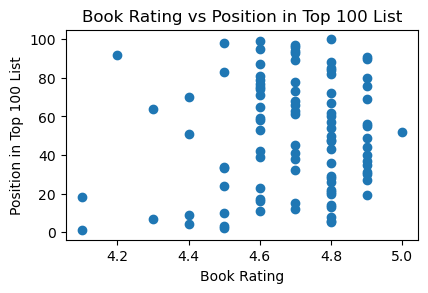

In [29]:
# Now to bring all of the correlations into graphs to better understand the data ...

plt.figure(figsize=(10, 6))

# Scatter plot for Book Rating and Position in Top 100 List
plt.subplot(2, 2, 1)
plt.scatter(trending_books_df['rating'], trending_books_df['Rank'])
plt.title('Book Rating vs Position in Top 100 List')
plt.xlabel('Book Rating')
plt.ylabel('Position in Top 100 List')

Text(0, 0.5, 'Position in Top 100 List')

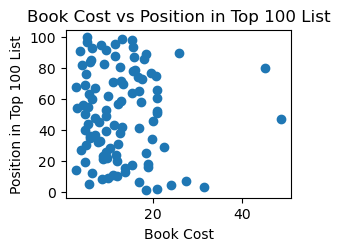

In [30]:
# Scatter plot for Book Cost and Position in Top 100 List
plt.subplot(2, 2, 2)
plt.scatter(trending_books_df['book_price'], trending_books_df['Rank'])
plt.title('Book Cost vs Position in Top 100 List')
plt.xlabel('Book Cost')
plt.ylabel('Position in Top 100 List')

Text(0, 0.5, 'Length of Review')

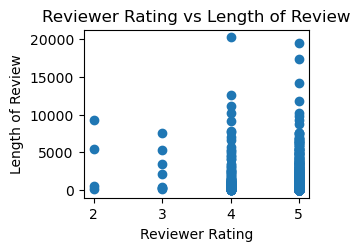

In [31]:
# Scatter plot for Reviewer Rating and Length of Review
plt.subplot(2, 2, 3)
plt.scatter(top_books_reviews['reviewer_rating'], top_books_reviews['review_length'])
plt.title('Reviewer Rating vs Length of Review')
plt.xlabel('Reviewer Rating')
plt.ylabel('Length of Review')

In [32]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [33]:
# Close the connection to the SQLite database
conn.close()